In [1]:
import pandas as pd   #data processing
import re             #regular expressions
import seaborn as sns #data visualization
import numpy as np    #array processing
import matplotlib.pyplot as plt  #data visualization
from bs4 import BeautifulSoup    #handling HTML 
from collections import Counter  #container datatypes
from wordcloud import WordCloud  #data visualization
from nltk.corpus import stopwords# Natural Language toolkit
from sklearn.feature_extraction.text import TfidfTransformer #TF-IDF
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE     #Oversampling
from imblearn.pipeline import make_pipeline  #Pipeline is just an abstract notion for performing sequence of different transformations
from nltk.stem import WordNetLemmatizer      #Lemmatization
from nltk.tokenize import WordPunctTokenizer #Tokenizer 


import warnings

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import files
files.upload()

Saving train_E6oV3lV.csv to train_E6oV3lV.csv


{'train_E6oV3lV.csv': b'id,label,tweet\n1,0, @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run\n2,0,@user @user thanks for #lyft credit i can\'t use cause they don\'t offer wheelchair vans in pdx.    #disapointed #getthanked\n3,0,  bihday your majesty\n4,0,#model   i love u take with u all the time in ur\xc3\xb0\xc2\x9f\xc2\x93\xc2\xb1!!! \xc3\xb0\xc2\x9f\xc2\x98\xc2\x99\xc3\xb0\xc2\x9f\xc2\x98\xc2\x8e\xc3\xb0\xc2\x9f\xc2\x91\xc2\x84\xc3\xb0\xc2\x9f\xc2\x91\xc2\x85\xc3\xb0\xc2\x9f\xc2\x92\xc2\xa6\xc3\xb0\xc2\x9f\xc2\x92\xc2\xa6\xc3\xb0\xc2\x9f\xc2\x92\xc2\xa6  \n5,0, factsguide: society now    #motivation\n6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  \n7,0, @user camping tomorrow @user @user @user @user @user @user @user danny\xc3\xa2\xc2\x80\xc2\xa6\n8,0,the next school year is the year for exams.\xc3\xb0\xc2\x9f\xc2\x98\xc2\xaf can\'t think about that \xc3\xb

In [3]:
data=pd.read_csv("train_E6oV3lV.csv")
data.info() #Datatypes, dimensions of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [4]:
data['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [5]:
data.head() 

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

In [6]:
#Understanding class distribution
positives = data['label'][data.label == 0]
negatives = data['label'][data.label == 1]
print('Number of positve tagged sentences is:  {}'.format(len(positives)))
print('Number of negative tagged sentences is: {}'.format(len(negatives)))
print('Total length of the data is:            {}'.format(data.shape[0]))

Number of positve tagged sentences is:  29720
Number of negative tagged sentences is: 2242
Total length of the data is:            31962


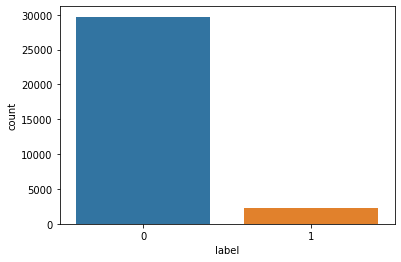

In [7]:
sns.countplot(x="label", data=data) 

In [8]:
print('Propotion of positive tagged sentences is:  {}'.format(len(positives)/data.shape[0]))
print('Propotion of negative tagged sentences is: {}'.format(len(negatives)/data.shape[0]))

Propotion of positive tagged sentences is:  0.9298542018647143
Propotion of negative tagged sentences is: 0.07014579813528565


**Data Cleaning**

1.The raw data is messy. It contains hashtags, user mentions, non ascii characters, punctuations, numbers, html entities, extra spaces, misspelled words,etc.

2.So, Data Pre-processing is the most important step prior to the model building in which we remove all the unnecessary qualities from the data.

Let us look at some of the examples


***HTML decode***:-

HTML encoding has not been converted to text and ended up in text field as ‘&amp’,’&quot’,etc. Decoding HTML to general text will be my first step of data preprocessing.

In [9]:
data.tweet[22]  #html decoding

"product of the day: happy man #wine tool  who's   it's the #weekend? time to open up &amp; drink up!"

In [10]:
example1 = BeautifulSoup(data.tweet[22], 'lxml')
print(example1.get_text())

product of the day: happy man #wine tool  who's   it's the #weekend? time to open up & drink up!


In [11]:
data.tweet[1] #converting don't to "do not"

"@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"

In [12]:
data.tweet[1].replace('don\'t','do not')

"@user @user thanks for #lyft credit i can't use cause they do not offer wheelchair vans in pdx.    #disapointed #getthanked"

***UTF-8 BOM*** :- 

By looking at the above entry, I can see strange patterns of characters “\xef\xbf\xbd”. After some researching, I found that these are UTF-8 BOM.

The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8.”

Let us ignore these bytes.



In [13]:
data.tweet[3]

'#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  '

In [14]:
newString = (data.tweet[3].encode('ascii', 'ignore')).decode("utf-8")
newString

'#model   i love u take with u all the time in ur!!!   '

**Removal of Hashtag symbol & User mentions**

Sometimes the text used with hashtag can provide useful information about the tweet. It might be a bit risky to get rid of all the text together with the hashtag.
So I decided to leave the text intact and just remove the ‘#’. 

In [15]:
data.tweet[1]

"@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"

In [16]:
import re
newString=re.sub('@[A-Za-z0-9]+','',data.tweet[1])
newstring=newString.replace("#","")
newstring

"  thanks for lyft credit i can't use cause they don't offer wheelchair vans in pdx.    disapointed getthanked"

***Removal of Numbers, Punctuations, Special Characters ***

In [17]:
data.tweet[8]

'we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â\x80¦ '

In [18]:
ab=re.sub("[^a-zA-Z]", " ", data.tweet[8])
ab

'we won    love the land     allin  cavs  champions  cleveland  clevelandcavaliers      '

***Removal of short words***

In [19]:
new_sentence=''
for i in ab.split():
  if len(i)>3:
    new_sentence=new_sentence+i+' '
new_sentence

'love land allin cavs champions cleveland clevelandcavaliers '

***Text Normalization***

There are 2 types of normalization techniques:-

1.**Stemming** is the process of converting the words of a sentence to its non-changing portions. In the example of amusing, amusement, and amused above, the stem would be amus.

2.**Lemmatization** is the process of converting the words of a sentence to its dictionary form. For example, given the words amusement, amusing, and amused, the lemma for each and all would be amuse.

Here, I prefer Lemmatization over Stemming since lemma results in dictionary form.

In [20]:
data.tweet[5]

'[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  '

In [21]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [22]:
lemmatizer = WordNetLemmatizer() 
new_sentence=''
for i in data.tweet[5].split():
  new_sentence=new_sentence+lemmatizer.lemmatize(i)+' '
new_sentence

'[2/2] huge fan fare and big talking before they leave. chaos and pay dispute when they get there. #allshowandnogo '

***Pre-Processing of Tweets***

In [23]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text
  
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have" }  

data['tweet'] = data['tweet'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [24]:
data.head()

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i cannot u...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

In [25]:
tok = WordPunctTokenizer()

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')                             #decode html
    souped = soup.get_text()                                       #get text
    newString = (souped.encode('ascii', 'ignore')).decode("utf-8") #encode to ascii
    newString=re.sub(r'@[A-Za-z0-9]+','',newString)                #removing user mentions
    letters_only = re.sub("[^a-zA-Z]", " ", newString)             #Fetching out only ascii characters
    lower_case = letters_only.lower()                              #converting everything to lowercase
    words = tok.tokenize(lower_case)                               #tokenize and join together to remove white spaces between words
    long_words=[]
    for i in words:
      if len(i)>3:                                                 #removing short words
        long_words.append(lemmatizer.lemmatize(i))                 #converting words to lemma
    return (" ".join(long_words)).strip()                          #combining to form sentence
  
cleaned_tweets = []
for t in data.tweet:
  cleaned_tweets.append(tweet_cleaner(t))
cleaned_tweets[:5]

['when father dysfunctional selfish drag kid into dysfunction',
 'thanks lyft credit cannot cause they offer wheelchair van disapointed getthanked',
 'bihday your majesty',
 'model love take with time',
 'factsguide society motivation']

In [26]:
data['cleaned_tweets']=cleaned_tweets #creating new dataframe

In [27]:
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['cleaned_tweets'].apply(word_count) 
data.head()

id  label  ...                                     cleaned_tweets word count
0   1      0  ...  when father dysfunctional selfish drag kid int...          8
1   2      0  ...  thanks lyft credit cannot cause they offer whe...         11
2   3      0  ...                                bihday your majesty          3
3   4      0  ...                          model love take with time          5
4   5      0  ...                      factsguide society motivation          3

[5 rows x 5 columns]

In [28]:
# get most common words in training dataset
all_words = []
for line in list(data['cleaned_tweets']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(25)

[('love', 2874),
 ('this', 2686),
 ('with', 2531),
 ('that', 2061),
 ('have', 2018),
 ('your', 1704),
 ('happy', 1700),
 ('will', 1625),
 ('just', 1365),
 ('when', 1269),
 ('life', 1267),
 ('time', 1262),
 ('like', 1222),
 ('what', 1169),
 ('today', 1105),
 ('from', 1059),
 ('father', 956),
 ('thankful', 952),
 ('positive', 938),
 ('people', 894),
 ('good', 877),
 ('bihday', 873),
 ('about', 871),
 ('make', 848),
 ('smile', 846)]

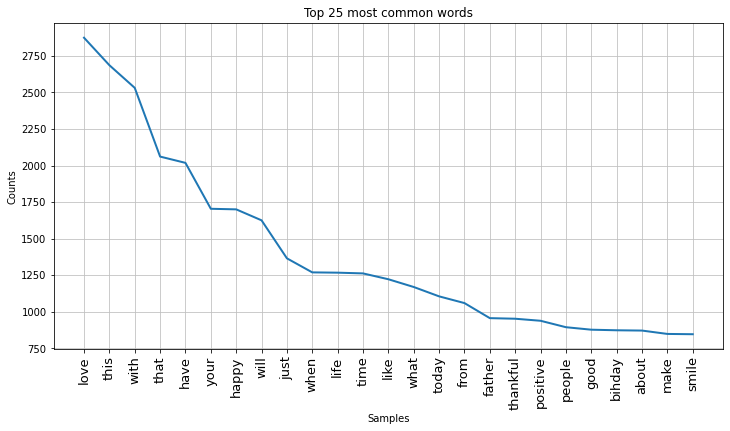

In [29]:
plt.figure(figsize=(12,6))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25)

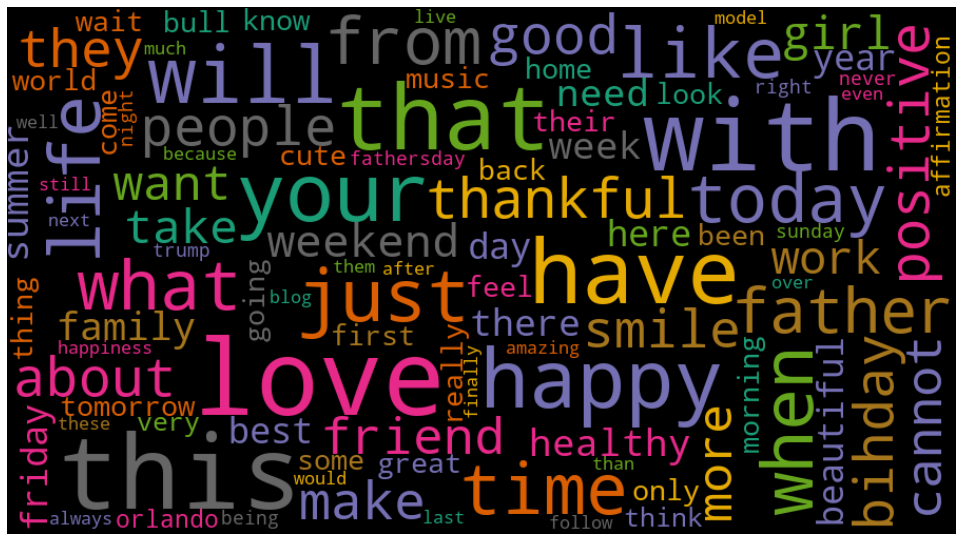

In [30]:
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=100,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Dark2',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us dive into the concept of embeddings

***Why embeddings?***

Machine Learning algorithm can understand only numbers but not raw string. Thats the reason why we have to convert the text to numeric form before feeding into machine learning model.

***Embeddings***:

Embeddings are the numerical representation of the text.

***Different types of embeddings***:

1. Frequency based:- Count Vectorizer, TF-IDF

2. Prediction based:- Word2Vec

***Feature Extraction ***

**Term Frequency-Inverse Document Frequency**

1.TF-IDF, short for term frequency–inverse document frequency, is a numeric measure that is use to score the importance of a word in a document based on how often did it appear in that document and a given collection of documents. 

2.The intuition for this measure is : If a word appears frequently in a document, then it should be important and we should give that word a high score. But if a word appears in too many other documents, it’s probably not a unique identifier, therefore we should assign a lower score to that word. 

3,The math formula for this measure :

tfidf(t,d,D)=tf(t,d)×idf(t,D)

Where t denotes the terms; d denotes each document; D denotes the collection of documents.

Let us build the feature space using **TF-IDF**

In [31]:
tvec = TfidfVectorizer(stop_words=None, max_features=1000,min_df=2) #max_features=Max no. of words to be considered, min-df=Min frequency of word 
tfidf = tvec.fit_transform(data['cleaned_tweets'])
tfidf.shape  #every document is represented with 1000 features

(31962, 1000)

**Original Imbalance Dataset**

In [34]:
y=np.array(data.label)
x_tr,x_val,y_tr,y_val=train_test_split(tfidf,y,test_size=0.2,random_state=77) #Split data into training and validation data initially

***TF-IDF + Logistic Regression + Imbalanced dataset***

In [35]:
lr = LogisticRegression()
lr_fit =lr.fit(x_tr,y_tr)
prediction = lr_fit.predict(x_val)
print(classification_report(y_val,prediction))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5954
           1       0.83      0.34      0.48       439

    accuracy                           0.95      6393
   macro avg       0.89      0.67      0.73      6393
weighted avg       0.94      0.95      0.94      6393



Let us handle the class imbalance problem now using 2 techniques

***Class Weights***

We can overcome the class imbalance problem by increasing the importance to the minority class samples by assigning higher class weights to minory class.

  ***TF-IDF + Logistic Regression + Auto Balanced Class Weights***

scikit module automatically assigns the class weights depending upon the class distribution.

Let us try with that initially.



In [36]:
lr = LogisticRegression(class_weight='balanced')
# Fit..
lr.fit(x_tr, y_tr)
# Predict..
y_pred = lr.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.87      0.93      5954
           1       0.32      0.82      0.46       439

    accuracy                           0.87      6393
   macro avg       0.65      0.85      0.70      6393
weighted avg       0.94      0.87      0.89      6393



***TF-IDF+ Logistic Regression + SMOTE***

In [37]:
sm = SMOTE(random_state=777,ratio=0.225)
X_res, y_res = sm.fit_resample(x_tr,y_tr)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(x_tr.shape)
print(X_res.shape)

(25569, 1000)
(29113, 1000)


In [ ]:
lr = LogisticRegression()
lr_fit =lr.fit(X_res,y_res)
prediction = lr_fit.predict(x_val)
print(classification_report(y_val,prediction))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5954
           1       0.65      0.54      0.59       439

    accuracy                           0.95      6393
   macro avg       0.81      0.76      0.78      6393
weighted avg       0.94      0.95      0.95      6393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Observation**

We have achieved better results in case of **SMOTE** than **auto - balance**.


LSTM

a) The problem with Neural Network is quick generalization and prediction is made by different combinations of inputs. 

b)This is a problem when the prediction has to made by capturing the sequential information from the input rather than trying out different combinations of the input.

c) Here comes RNN. But, RNN's suffer from the vanishing gradient due to which it cannot learn the long term dependencies. Thats why we go with LSTMs.

d) **Long Short Term Memory** models can capture the long range dependencies which is a shortcome of Recurrent Neural Network.

Let us model the problem as Seq2Seq modeling where the input is a sequence of words and output is a class label

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import *
from keras.layers import *
from keras.callbacks import *

x_tr,x_val,y_tr,y_val=train_test_split(np.array(data['cleaned_tweets']),y,test_size=0.2,random_state=77) #Split data into training and validation data initially

## Tokenize the sentences
tokenizer = Tokenizer()

tokenizer.fit_on_texts(list(x_tr))

train_X = tokenizer.texts_to_sequences(x_tr) #Generating sequence with index of the word
val_X = tokenizer.texts_to_sequences(x_val)

## Pad the sentences to max length of sequence so that every sequence is of same length
train_X = pad_sequences(train_X, maxlen=100)
val_X = pad_sequences(val_X, maxlen=100)


Using TensorFlow backend.


In [ ]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #padding

***Intrinsic Regularization***

1.Early stopping is a method that allows you to specify an arbitrary large number of training epochs 
and stop training once the model performance stops improving on a hold out validation dataset.

***Extrinsic Regularization***:-

1.Dropout is a regularization method where neurons are randomly dropped from the neural network and weights are not involved during forward propagation as well as the backward propagation.

2.This has the effect of reducing overfitting and improving model performance.

Let us learn the embeddings from the scratch using keras embedding layer.

In [ ]:
model=Sequential()
#Every word is projected in 300 dimensional space
#input_length=Maximum length of sequence
#trainable=True represents that embeddings to be learnt during back propagation
model.add(Embedding(size_of_vocabulary,300,input_length=100,trainable=True)) 
model.add(LSTM(32,return_sequences=True,dropout=0.2)) #No. of LSTM cells
model.add(GlobalMaxPooling1D())
model.add(Dense(16,activation='relu')) #No. of hidden nodes
model.add(Dense(1,activation='sigmoid')) 
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) #Add loss function, metrics, optimizer
#Patience :- Adding a delay in terms of the number of epochs on which we would like to see no improvement.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)  #Early stoppage
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)  #To save the best model after every epoch
print(model.summary()) #To know about layers and no. of parameters at each layer





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          8655900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           42624     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 8,699,069
Trainable par

In [ ]:
history = model.fit(np.array(train_X),np.array(y_tr),batch_size=300,epochs=10,validation_data=(np.array(val_X),np.array(y_val)),verbose=1,callbacks=[es,mc])




Train on 25569 samples, validate on 6393 samples
Epoch 1/10





25569/25569 [==============================] - 27s 1ms/step - loss: 0.3812 - acc: 0.9075 - val_loss: 0.2486 - val_acc: 0.9313

Epoch 00001: val_loss improved from inf to 0.24856, saving model to best_model.h5
Epoch 2/10
25569/25569 [==============================] - 21s 839us/step - loss: 0.2152 - acc: 0.9295 - val_loss: 0.1654 - val_acc: 0.9313

Epoch 00002: val_loss improved from 0.24856 to 0.16542, saving model to best_model.h5
Epoch 3/10
25569/25569 [==============================] - 21s 831us/step - loss: 0.1188 - acc: 0.9562 - val_loss: 0.1247 - val_acc: 0.9646

Epoch 00003: val_loss improved from 0.16542 to 0.12473, saving model to best_model.h5
Epoch 4/10
25569/25569 [==============================] - 21s 832us/step - loss: 0.0668 - acc: 0.9844 - val_loss: 0.1145 - val_acc: 0.9657

Epoch 00004: val_loss improved from 0.12473 to 0.11447, saving model to best_model.h5
Epoch 5/10
25569/25569 [=====================

**Observation**:

1.After epoch 3, validation loss keeps increasing as the training loss goes down and we achieve the best model at epoch 3 is saved using Model Checkpoints since the model obtained at the end of epoch is not the best one.

In [ ]:
from keras.models import load_model
saved_model = load_model('best_model.h5')

y_pred=model.predict_classes(np.array(val_X))

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5954
           1       0.80      0.63      0.70       439

    accuracy                           0.96      6393
   macro avg       0.88      0.81      0.84      6393
weighted avg       0.96      0.96      0.96      6393



Therefore we can achieve high accuracy using **RNN**